# Tutorial: Numerical Method for differential equation

In [8]:
import numpy as np
import matplotlib.pyplot as plt

## Euler's Method

Example:


$
\begin{equation}
\cfrac{dx}{dt} = -x^3 + sin(t)
\end{equation}
$

In [ ]:
def f(x,t):
    return -x**3 + np.sin(t)

h = 0.001
ts = np.arange(0, 10+h, h)
x_list = []
t_list = []

# Initial Condition
x = 0
t = 0

x_list.append(x)
t_list.append(t)

for t in ts:
    x_prev = x_list[-1]
    t_prev = t_list[-1]
    x_next = x_prev + h * f(x_prev, t_prev)
    x_list.append(x_next)
    t_list.append(t_prev+h)

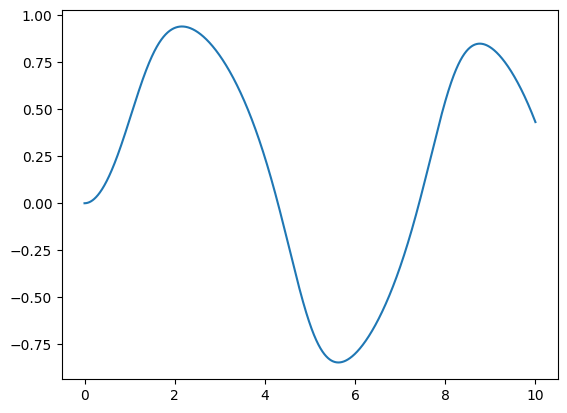

In [ ]:
# Visualization
plt.plot(t_list, x_list)
plt.show()

## More compressed way

In [ ]:
def f(x,t):
    return -x**3 + np.sin(t)

h = 0.001
ts = np.arange(0, 10+h, h)
x_t = []

x = 0 # Initial Condition
for t in ts:
    x_t.append(x) # insert x_prev in x_list
    x = x + h * f(x,t) # calculate x_next (Left part x) from x_prev (before update, Right part x)

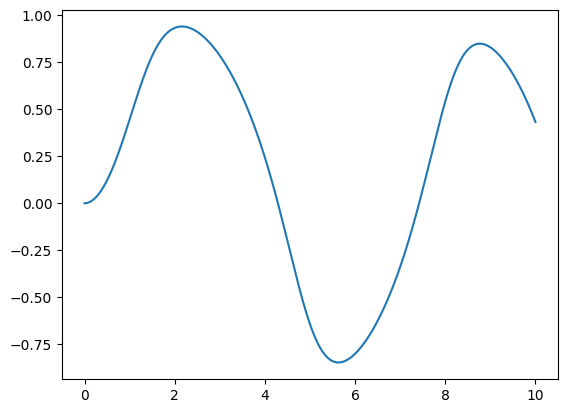

In [ ]:
# Visualization
plt.plot(ts, x_t)
plt.show()

## Runge-Kutta Method 4-th order

Example:

\begin{equation}
\cfrac{dx}{dt} = \cfrac{1}{x^2+t^2}
\end{equation}

with $u\equiv\cfrac{t}{1+t}$, $t\in[0,\infty) \rightarrow u\in[0,1]$

In [ ]:
def g(x,u):
    return 1/(x**2 *(1-u)**2+u**2)

h = 0.001
us = np.arange(0, 1, h)
x_t = []
ts = []

x = 1 # Initial Condition
for u in us:
    ts.append(u/(1-u))
    x_t.append(x)
    k1 = h*g(x,u)
    k2 = h*g(x+0.5*k1,u+0.5*h)
    k3 = h*g(x+0.5*k2,u+0.5*h)
    k4 = h*g(x+k3,u+h)
    x = x + (k1+2*k2+2*k3+k4)/6

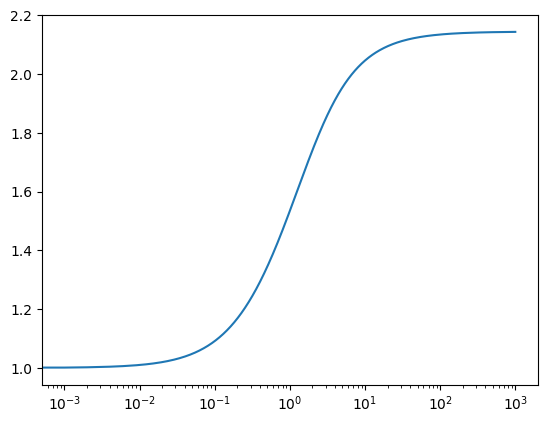

In [ ]:
# Visualization
plt.plot(ts, x_t)
plt.xscale("log")
plt.show()

## Numerical Method in various ODE: Simultaneous example
### Exercise 8.2: the Lotka-Volterra equation
$
\begin{align}
\cfrac{dx}{dt} &= \alpha x - \beta xy \\
\cfrac{dy}{dt} &= \gamma x y - \delta y
\end{align}
$


Let's $\boldsymbol{r}\equiv(x,y)$, then $\frac{d\boldsymbol{f}(\boldsymbol{r},t)}{dt} \equiv (\alpha x - \beta xy , \gamma x y - \delta y)$

In [ ]:
alpha = 1
beta = 0.5
gamma = 0.5
delta = 2

def f_vec(r,t):
    x = r[0]
    y = r[1]
    fx = alpha*x - beta*x*y
    fy = gamma*x*y-delta*y
    return np.array([fx,fy])

In [ ]:
h = 0.001
ts = np.arange(0, 30+h, h)
x_t = []
y_t = []

r = np.array([2, 2])
for t in ts:
    x_t.append(r[0])
    y_t.append(r[1])
    k1 = h*f_vec(r,t)
    k2 = h*f_vec(r+0.5*k1,t+0.5*h)
    k3 = h*f_vec(r+0.5*k2,t+0.5*h)
    k4 = h*f_vec(r+k3,t+h)
    r = r + (k1+2*k2+2*k3+k4)/6

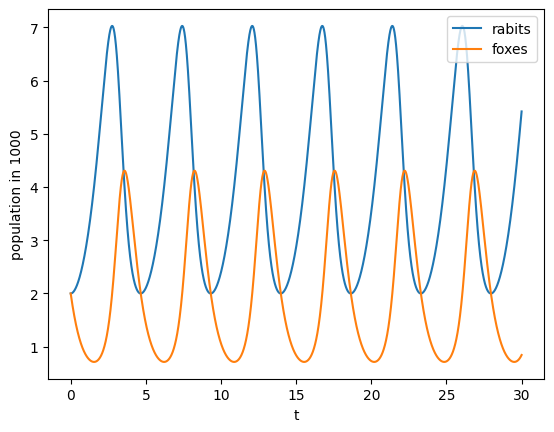

In [ ]:
# Visualization
plt.plot(ts,x_t,label='rabits')
plt.plot(ts,y_t,label='foxes')
plt.xlabel("t")
plt.ylabel('population in 1000')
plt.legend()
plt.show()

## Initial value problem ODE application in physical system
### Kepler problem with varying step size utilization

Adapative size for RK4
$ h' = h\rho^{1/4},\quad \text{where} \quad \rho \equiv \cfrac{30h\delta}{|x_1-x_2|}$

Take adaptive step size under below case manner

\begin{equation*}
      \begin{cases}
            \text{Our step ($h$) make error sufficiently small} &\text{$\rho > 1$} \\
            \text{Use $h'$ to make error $\delta$} &\text{$\rho < 1$}
      \end{cases}
\end{equation*}


In [2]:
class rksolve_adaptive():
    def __init__(self, adaptive=True, func=None) -> None:
        self.adaptive=adaptive
        self.f = func


    def estimate_delta(self,r,t,h):

        f = self.f
        k1 = h*f(r,t)
        k2 = h*f(r+0.5*k1,t+0.5*h)
        k3 = h*f(r+0.5*k2,t+0.5*h)
        k4 = h*f(r+k3,t+h)
        return (k1+2*k2+2*k3+k4)/6

    def iterate(self,a,b,delta=1):
        r0 = np.array(self.initial_conditions)
        h = (b-a)/10000
        solution = []
        time = []
        r = r0
        t = a

        solution.append(r)
        time.append(t)

        while t<b:
            # estimating ro
            if self.adaptive:
                r1 = r + self.estimate_delta(r,t,h)
                r1 += self.estimate_delta(r1,t+h,h)

                r2 = r + self.estimate_delta(r,t,2*h)
                difference = r1 - r2
                try:
                    rho = 30*h*delta/np.sqrt(difference[0]**2 + difference[1]**2)
                except:
            else:
                rho = 1

            if rho<1:
                h = h*rho**(1/4)
            else:
                pass

            t = t + h
            r = r + self.estimate_delta(r, t, h)
            solution.append(r)
            time.append(t)


        self.h = h
        self.solution = np.array(solution)
        self.t = time

In [3]:
def f(r,t):
    G = 6.67e-11
    M = 1.9e+30
    x,y,vx,vy = r

    Dx = vx
    Dy = vy

    R = np.sqrt(x**2 + y**2)

    Dvx = -G*M*x/R**3
    Dvy = -G*M*y/R**3

    return np.array([Dx,Dy,Dvx,Dvy])

In [4]:
prob = rksolve_adaptive(adaptive=False, func=f)


R = 1.496e11
T = 3.156e7  # 1-year second
v = 2*np.pi*R/T
prob.initial_conditions = [4e12,0,0,500]

delta = 1e3/365/24/60/60 # 1 km per year-time (unit time error)
prob.iterate(0,T*50,delta=delta)


x_static = prob.solution[:,0]
y_static = prob.solution[:,1]

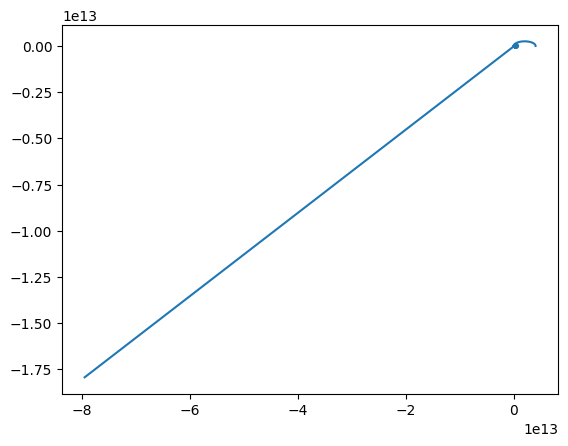

In [5]:
plt.plot(x_static, y_static)
plt.show()

In [6]:
prob = rksolve_adaptive(adaptive=True, func=f)


R = 1.496e11
T = 3.156e7  # 1-year second
v = 2*np.pi*R/T
prob.initial_conditions = [4e12,0,0,500] # initial position of comet

delta = 1e3/365/24/60/60 # 1 km per year-time (unit time error)
prob.iterate(0,T*50,delta=delta)


x = prob.solution[:,0]
y = prob.solution[:,1]

<ipython-input-2-f67bcf20eb1e>:35: RuntimeWarning: divide by zero encountered in scalar divide
  rho = 30*h*delta/np.sqrt(difference[0]**2 + difference[1]**2)


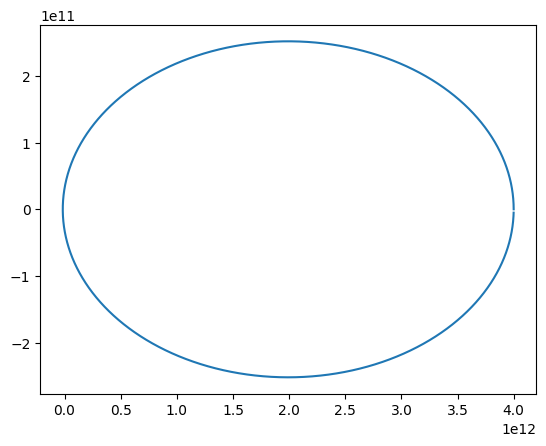

In [7]:
plt.plot(x,y)
plt.show()

## Boundary value problem
### Boundary value problem ODE application in physical system :

Ground state energy in a infinite well -  schrodinger equation


$
\begin{equation}
-\cfrac{\hbar^2}{2m}\cfrac{d^2\psi}{dx^2} + V(x)\psi(x) = E\psi(x)
\end{equation}
$

Make First Order Differential equation,

$
\begin{equation}
\cfrac{d\psi}{dx}=\phi, \quad \cfrac{d\phi}{dx} = \cfrac{2m}{\hbar^2}\left[V(x)-E\right]\psi
\end{equation}
$

then take vector function $\boldsymbol{f}$, as $\boldsymbol{f} = (d\psi/dx, d\phi/dx)$

In [13]:
# Constants
m = 9.1094e-31 # Mass of electron
hbar = 1.0546e-34 # Planck's constant over 2*pi
e = 1.6022e-19 # Electron charge
L = 5.2918e-11 # Bohr radius
N = 1000
h = L/N



# Potential function
def V(x):
    return 0.0

def vec_f(r,x,E):
    psi = r[0]
    phi = r[1]
    dpsi = phi
    dphi = (2*m/hbar**2)*(V(x)-E)*psi
    return np.array([dpsi,dphi])


# Calculate the wavefunction(psi) for a particular energy
# Especially, \psi(L) in given E
def solve(E):
    # boundary condition at x=0
    psi = 0.0
    # unknown boundary condition (initial slope)
    phi = 2.0
    r = np.array([psi,phi])
    psi_list = []
    for x in np.arange(0,L,h):
        psi_list.append(r[0])
        k1 = h*vec_f(r,x,E)
        k2 = h*vec_f(r+0.5*k1,x+0.5*h,E)
        k3 = h*vec_f(r+0.5*k2,x+0.5*h,E)
        k4 = h*vec_f(r+k3,x+h,E)
        r += (k1+2*k2+2*k3+k4)/6
    return r[0], psi_list

We use secant method for root finding method


<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Sekantenverfahren_Ani2.gif">

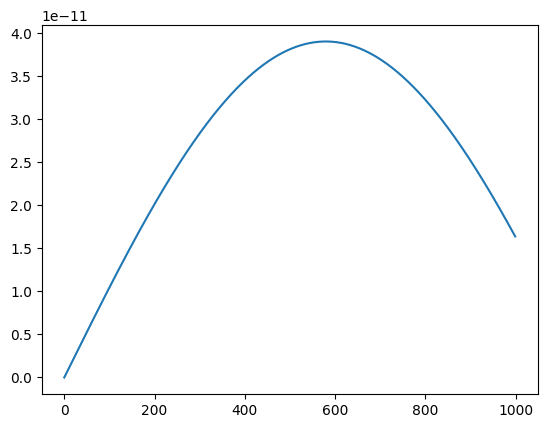

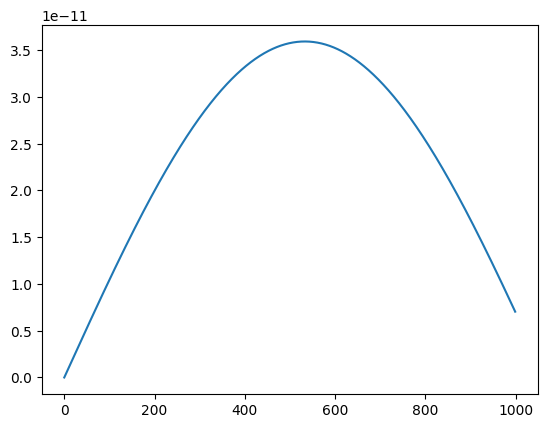

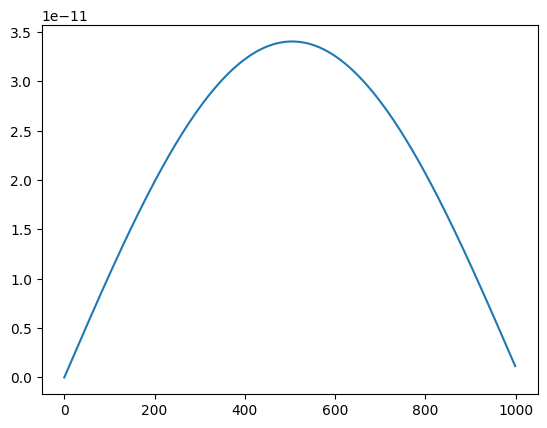

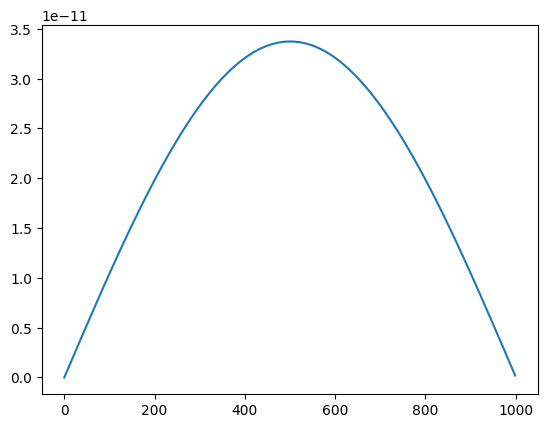

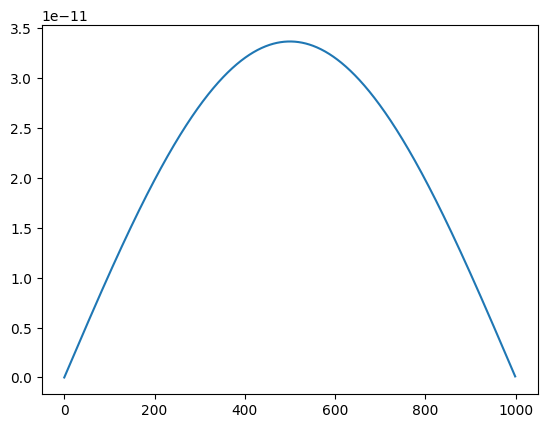

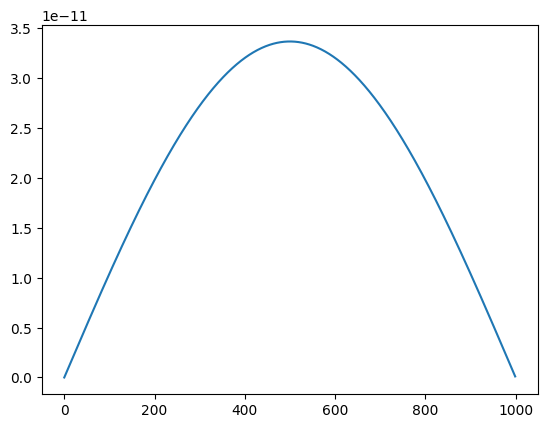

E = 134.2863717014795 eV


In [20]:
# Main program to find the energy using the secant method
# Converge to root, if initial values are sufficiently 'close' to the root
E1 = 0*e
E2 = 100*e
psi2, solutions = solve(E1)
target_epsilon = e/1000
while abs(E1-E2)>target_epsilon:
    # same with f(E1) = ..., f(E2) = ...
    psi1 = psi2
    psi2, solutions = solve(E2)


    E1, E2 = E2, E2-psi2*(E2-E1)/(psi2-psi1)
    # plt.plot(solutions)
    # plt.show()

print("E =", E2/e, "eV")

# Simple Neural Network application

In [ ]:
import torch
import torch.nn as nn

def tdn(x):
    return x.cpu().detach().numpy()


device = "cuda" if torch.cuda.is_available() else "cpu"

## ODE Equation: 1D Oscillator
Consider a damped harmonic oscillator described by the second-order ODE

\begin{equation}
\frac{d^2x}{dt^2} + 5\frac{dx}{dt} + 4x = 0, \quad x(0) = 1, \quad x'(0) = 0
\end{equation}
The analytical solution of this ODE is:
\begin{equation}
x(t) = \frac{1}{3}e^{-4t}(4e^{3t}-1)
\end{equation}

## 1. Neural Network Design

In [ ]:
class DampedHarmonicOscillatorNN(nn.Module):
    def __init__(self):
        super(DampedHarmonicOscillatorNN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


## 2-1. torch.autograd basic

In [ ]:
# Scalar function
a = torch.tensor([2.], requires_grad=True)
b = torch.tensor([6.], requires_grad=True)
Q = 3*a**3 - b**2
torch.autograd.grad(Q, a) # dQ_da; grad_outputs.T @ Jacobian

(tensor([36.]),)

In [ ]:
# Parallel Vector function
a = torch.tensor([2., 3., 4], requires_grad=True)
b = torch.tensor([6., 4., 2], requires_grad=True)

def Q(a,b):
    res = 3*a**3 - b**2
    return res

# Basically, parallel scalar function
# Q[0] = 3*a[0]**3-b[0]**2
# Q[1] = 3*a[1]**3-b[1]**2
# ...

print(Q(a,b))

tensor([-12.,  65., 188.], grad_fn=<SubBackward0>)


In [ ]:
# grad_output; The “vector” in the vector-Jacobian product
# create_graph; Allowing to compute higher order derivative products
torch.autograd.grad(Q(a,b), a, grad_outputs=torch.ones_like(Q(a,b)), create_graph=True) # dQ_da; grad_outputs.T @ Jacobian

(tensor([ 36.,  81., 144.], grad_fn=<MulBackward0>),)

$
J=\left(\begin{array}{ccc}
\frac{\partial \mathbf{y}}{\partial x_1} & \cdots & \frac{\partial \mathbf{y}}{\partial x_n}
\end{array}\right)=\left(\begin{array}{ccc}
\frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_n}
\end{array}\right)
\quad \to \quad J_{Q,a}= \begin{pmatrix}
\frac{\partial Q_1}{\partial a_1} & \frac{\partial Q_1}{\partial a_2} \\
\frac{\partial Q_2}{\partial a_1} & \frac{\partial Q_2}{\partial a_2}
\end{pmatrix}  $

In parallel vector function, we need only diagonal part (off-diagonal; meaningless)

In [ ]:
# create_graph - off; require_grads property is not retained
try:
    dqda = torch.autograd.grad(Q(a,b), a, grad_outputs=torch.ones_like(Q(a,b)), create_graph=False)[0]
    print(dqda)
    dqdaa = torch.autograd.grad(dqda, a, grad_outputs=torch.ones_like(dqda))
except Exception as e:
    print(e)

tensor([ 36.,  81., 144.])
element 0 of tensors does not require grad and does not have a grad_fn


In [ ]:
# create_graph - on
try:
    dqda = torch.autograd.grad(Q(a,b), a, grad_outputs=torch.ones_like(Q(a,b)), create_graph=True)[0]
    print(dqda)
    dqdaa = torch.autograd.grad(dqda, a, grad_outputs=torch.ones_like(dqda))[0]
    print(dqdaa)
except Exception as e:
    print(e)

tensor([ 36.,  81., 144.], grad_fn=<MulBackward0>)
tensor([36., 54., 72.])


In [ ]:
# We can explict calculate Jacobian matrix by another predefined function
# print("Jacobian J_Q,a: \n", torch.autograd.functional.jacobian(Q, (a,b), create_graph=True)[0])
# print("J.T @ v: ", torch.autograd.functional.jacobian(Q, (a,b), create_graph=True)[0] @ torch.ones_like(Q(a,b)))

## 2-2. Define Residual

In [ ]:
def damped_oscillator_residual(t, x):
    # Calculate the first derivative dx/dt
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]

    # Calculate the second derivative d2x/dt2
    d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]

    # Define the residual of the ODE: d2x/dt2 + 5 * dx/dt + 4 * y
    residual = d2x_dt2 + 5 * dx_dt + 4 * x

    return residual


## 3. Gathering Dataset & Optimization

In [ ]:
ts = torch.arange(0 ,5+0.01, 0.01).view(-1,1)

In [ ]:
import torch.optim as optim

model = DampedHarmonicOscillatorNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
for epoch in range(num_epochs):

    optimizer.zero_grad()

    t_train = ts.requires_grad_(True).to(device)

    x = model(t_train)
    residual = damped_oscillator_residual(t_train, x)

    loss = torch.mean(residual**2)
    loss.backward()
    optimizer.step()

    ### Initial condition 1
    optimizer.zero_grad()

    t_init = torch.zeros(10).view(-1, 1)
    t_init = t_init.to(device)

    x_init = model(t_init)
    initial_residual = x_init-1

    loss = torch.mean(initial_residual**2)
    loss.backward()
    optimizer.step()

    ### Initial condition 2
    optimizer.zero_grad()

    t_init = torch.zeros(10).view(-1, 1)
    t_init = t_init.requires_grad_(True).to(device)

    x_init = model(t_init)
    dx_dt_init = torch.autograd.grad(x_init, t_init, grad_outputs=torch.ones_like(x_init), create_graph=True)[0]
    initial_dt_residual =  dx_dt_init-0

    loss = torch.mean(initial_dt_residual**2)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')


Epoch [100/1000], Loss: 0.03714228
Epoch [200/1000], Loss: 0.00170320
Epoch [300/1000], Loss: 0.00015114
Epoch [400/1000], Loss: 0.00003236
Epoch [500/1000], Loss: 0.00000977
Epoch [600/1000], Loss: 0.00000367
Epoch [700/1000], Loss: 0.00012148
Epoch [800/1000], Loss: 0.00000071
Epoch [900/1000], Loss: 0.00000013
Epoch [1000/1000], Loss: 0.00000021


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t_test = torch.arange(0, 5+0.01, 0.01).view(-1,1)
def x_analytical(t):
    return 1/3*torch.exp(-4 * t) * (4*torch.exp(3 * t) - 1)
x_true = x_analytical(t_test)

model.eval()
with torch.no_grad():
    x_pred = model(t_test.to(device))

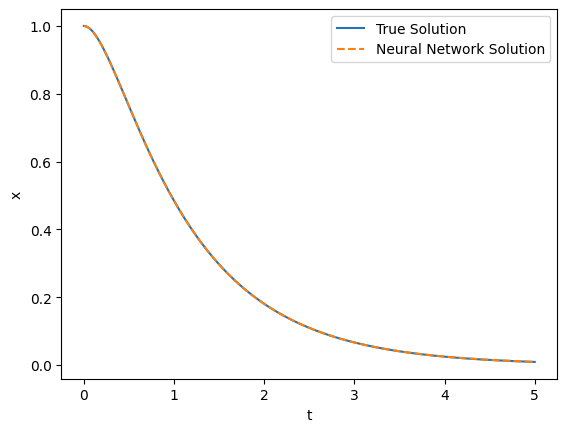

In [ ]:
plt.plot(tdn(t_test), tdn(x_true), label='True Solution')
plt.plot(tdn(t_test), tdn(x_pred), label='Neural Network Solution', linestyle='--')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()
